# Detecting epileptic seizures from EEG signals


## CHB MIT, Dataset University


### 0. First steps
1. Download the ZIP file https://physionet.org/physiobank/database/chbmit/
2. Download the files in the repository https://github.com/stiwarih/hssyp/tree/master/project to the same folder as the notebook and unzip the csv files. To run this notebook, please run the first cells to install and load the necessary libraries.

In [ ]:
!pip install antropy
# Please start by installing those two Python packages
!pip3 install pyedflib
!pip3 install PyWavelets

import pyedflib as edf
import numpy as np
import glob
import pandas as pd
import random
import antropy as ent
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.7 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16879 sha256=93e92846864990a661679324d8e71585869d83548e987dd21b260b3f152a1be5
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.3 MB/s eta 0:00:00


## 1 Introduction

### 1.1 Epilepsy and Seizures

Epilepsy is the most common neurological disorder in which clusters of nerve cells (neurons) in
the brain sometimes signal abnormally and cause seizures. Currently it affects 60 million people
world-wide. Normal function of neurons is to generate electrical and chemical signals that
act on other neurons, which in turn cause secondary actions leading to a desired behavior. During a
seizure, many neurons try to send signals at the same time; this abnormal surge of excessive elec-
trical activity causes involuntary movements, and may cause a loss of control, lapse of attention
or whole-body convulsion.

The introduction of new anti-epileptic drugs has provided most patients the ability to control their
seizures, however, three in ten patients with epilepsy continue to have seizures despite treat-
ment. Given the nature of the disease is quite unpredictable, patients often experience high levels
of anxiety, mainly due to the impending loss of control and/or awareness during a seizure.  Thus,
prediction is key to minimizing the anxiety and fear experienced by the patient, and prediction
begins with detection. A device able to detect seizures quickly could vastly improve patient care.


### 1.2 A classification problem

Seizure detection is usually done using scalp electroencephalogram (EEG), a non-invasive, multi-
channel recording of the brain's electrical activity. Classification between normal activity and
a seizure is usually done in two steps: noise filtering and classification. We propose here two
approaches to noise filtering: use two transforms, Fourier and Discrete wavelets, to filter
the data but also extract the useful information and structure behind the signals. We will test
classical models of classification using Python's sklearn libraries to run them.


### 1.3 Data

A study was conducted at the Children's Hospital Boston where EEG was recorded on pediatric
subjects with intractable (i.e. epileptic) seizures. There were 22 subjects in the study: 5 male, ages
3-22, and 17 females, ages 1.5-19; subject 21 was evaluated a second time 1.5 years later, thus re-
sulting in 23 cases. Each case contains between 9 and 42 continuous .edf fles from a single subject,
typically consisting of one hour each. Prior to measuring, subjects were taken of of any anti-
seizure medication. The files can be found at https://physionet.org/physiobank/database/chbmit/


### 1.4 EEG Samples

Most of the EEG files have 23 recordings from electrodes placed around the head of the patient.
Figures 1 and 2 present two EEG recordings of 40 seconds each. The first one was recorded at 1:43pm,
while the patient was awake, and so should represent normal activity of the brain. The second
one was recorded 50 minutes later. Within this 40 seconds, the patient experiences one epileptic
seizure. As the size of the EEG makes it diffcult to assess how much bigger the amplitudes are
when the patient is experiencing a seizure, Figure 3 zooms in on one channel for the non-seizure
and seizure activity. Here we begin to see a marked difference between the two.

In [ ]:
WINDOW_STEP = 256

files = glob.glob('chb2*.edf')

seizure_period_foreach_file = [
    (2996, 3036),
    (1467, 1494),
    (1732, 1772),
    (1015, 1066),
    (1720, 1810),
    (327, 420),
    (1862, 1963),
    (130, 212),
    (2972, 3053),
    (362, 414),
    (731, 796),
    (432, 501),
    (2162, 2214),
    (7804, 7853),
    (1679, 1781),
    (3782, 3898),
    (417, 532),
    (1086, 1196),
    (2317, 2413),
    (2451, 2571),
    (2348, 2465),
    (327, 347),
    (6211, 6231),
    (12500, 12516),
    (10833, 10845),
    (506, 519),
    (7799, 7811),
    (9387, 9403),
    (4920, 5006),
    (3285, 3381),
    (13688, 13831),
    (2670, 2841),
    (2856, 3046),
    (2988, 3122),
    (2417, 2577),
    (2083, 2347),
    (12231, 12295),
    (2951, 3030),
    (9196, 9267),
    (5299, 5361),
    (6313, 6348),
    (6888, 6958),
    (2382, 2447),
    (3021, 3079),
    (3801, 3877),
    (4618, 4707),
    (1383, 1437),
]

seizure_period_concat_with_file = zip(files, seizure_period_foreach_file)

seizure_period_concat_with_file = [(file_name, start, end)
                                    for file_name, (start, end) in seizure_period_concat_with_file]

signals = []

for file in files:
    with edf.EdfReader(file) as edf_reader:
        signal_labels = edf_reader.getSignalLabels()

        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')

        buffers = np.zeros((2, edf_reader.getNSamples()[0]))

        buffers[0] = edf_reader.readSignal(fz_cz_index)
        buffers[1] = edf_reader.readSignal(cz_pz_index)

        array_buffer = np.array(buffers)
        signals.append(array_buffer)

len(signals)

50

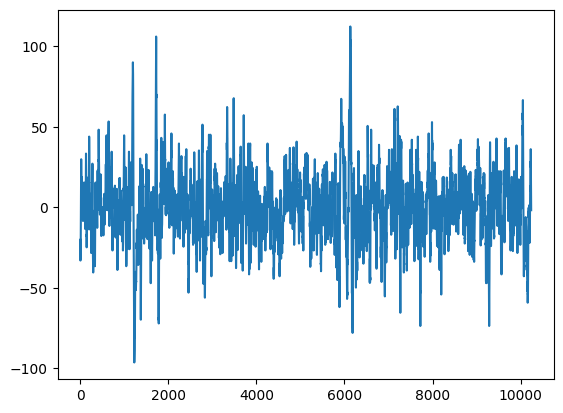

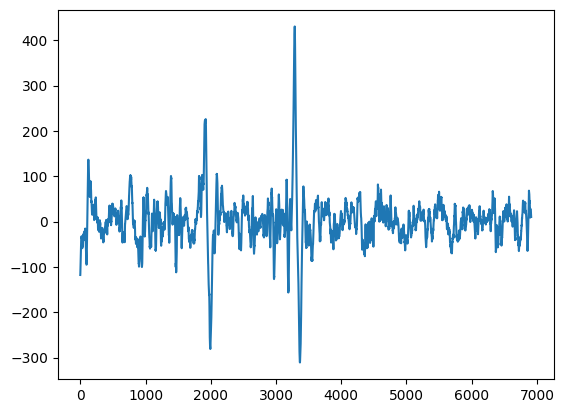

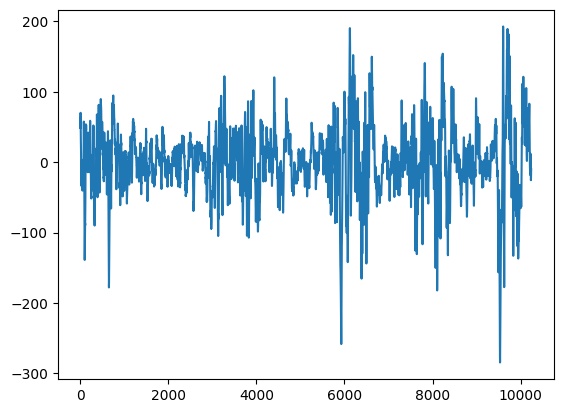

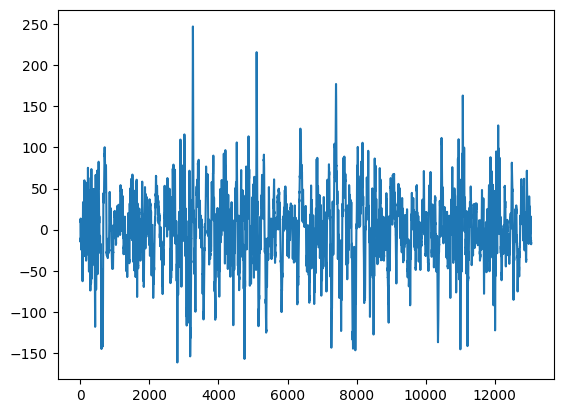

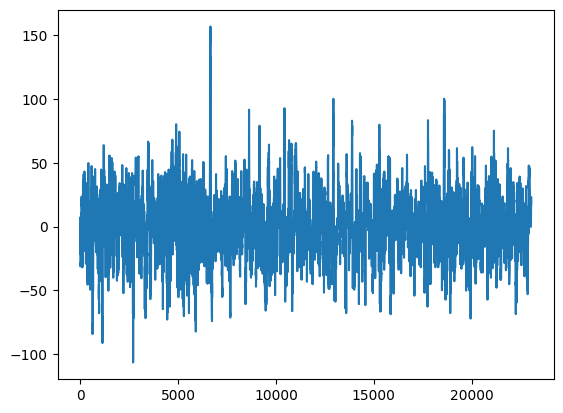

In [ ]:
sample_signals = seizure_period_concat_with_file[0:5]

for i, signal in enumerate(sample_signals):
    filename, start, end = signal
    plt.plot(signals[i][0][start * WINDOW_STEP:end * WINDOW_STEP])
    plt.show()

Getting seizure part of signal and labeling it with 5 * 256 window.
We use 5 seconds window to label seizure part of signal and getting more data

In [ ]:
WINDOW_SIZE = 5 * WINDOW_STEP

seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
seizure_y_labels = []

for index in range(len(signals)):
    try:
        start_time = seizure_period_concat_with_file[index][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[index][2] * WINDOW_STEP
        for j in range(start_time, end_time, WINDOW_SIZE):
            seizure_signals = np.append(seizure_signals,
                                        np.array([signals[index][:, j:j + WINDOW_SIZE]]), axis=0)
            seizure_y_labels.append(1)
    except:
        continue

seizure_signals.shape

(572, 2, 1280)

Plot some of seizure signals

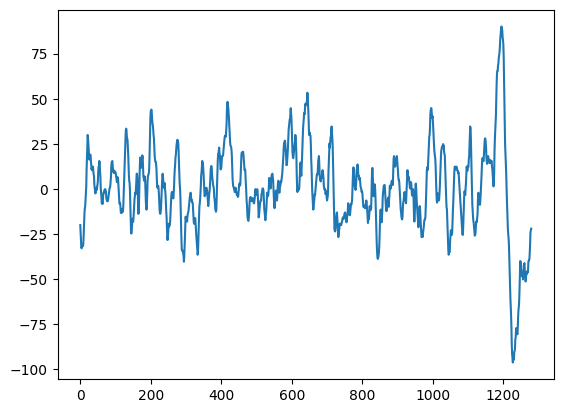

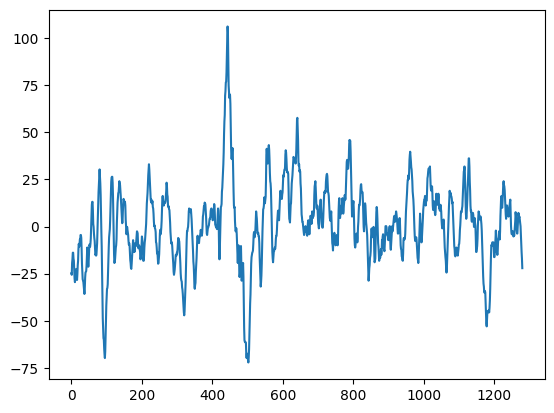

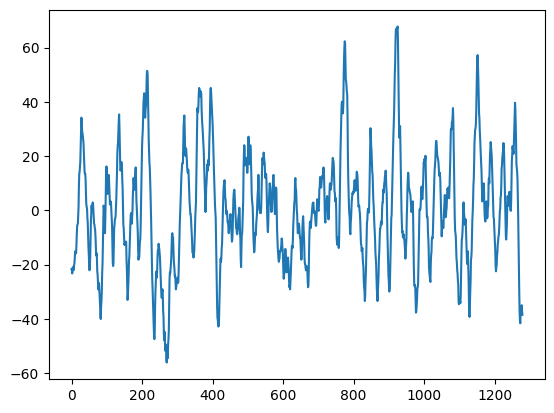

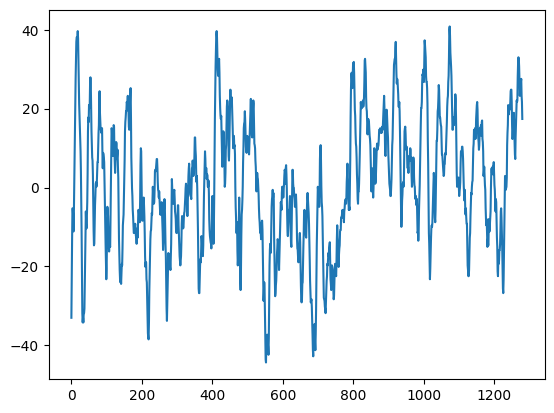

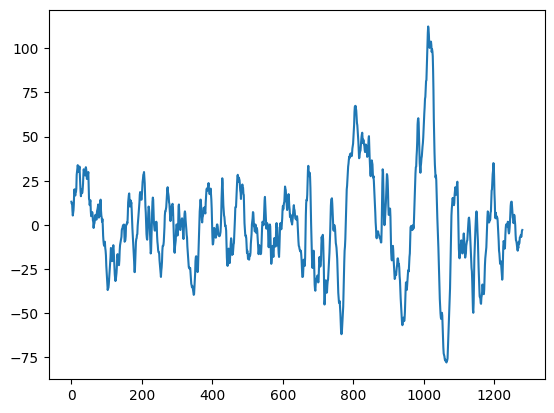

In [ ]:
sample_signals = seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

Deleting first 5% & last 5% signals (noise)

In [ ]:
def remove_noise(signals):
    for index in range(len(signals)):
        low_range = int(0.05 * len(signals[i][0]))
        high_range = int(0.95*len(signals[i][0]))
        signals[i] = signals[i][:,low_range:high_range]

    return signals

signals_without_noise = remove_noise(signals)

len(signals_without_noise)

50

Removing the seizure part of each signal

In [ ]:
for i in range(len(signals_without_noise)):
    try:
        start_time = seizure_period_concat_with_file[i][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[i][2] * WINDOW_STEP
        signals_without_noise[i] = np.delete(signals_without_noise[i], np.s_[start_time:end_time], axis=1)
    except:
        continue

len(signals_without_noise)

50

Getting non-seizure part of each signal & labeling each 5 * 256 random window

In [ ]:
WINDOW_SIZE = 5 * WINDOW_STEP

non_seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
non_seizure_y_labels = []

for index in range(len(signals_without_noise)):
    try:
        for j in range(WINDOW_STEP):
            random_index = random.randint(0, len(signals_without_noise[i][0]) - WINDOW_SIZE)
            non_seizure_signals = np.append(non_seizure_signals,
                                        np.array([signals_without_noise[index][:, random_index:random_index + WINDOW_SIZE]]), axis=0)
            non_seizure_y_labels.append(0)
    except:
        continue

non_seizure_signals.shape

(6277, 2, 1280)

Plot non-seizure signals

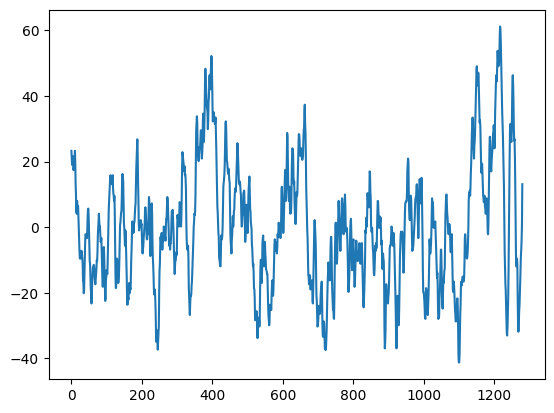

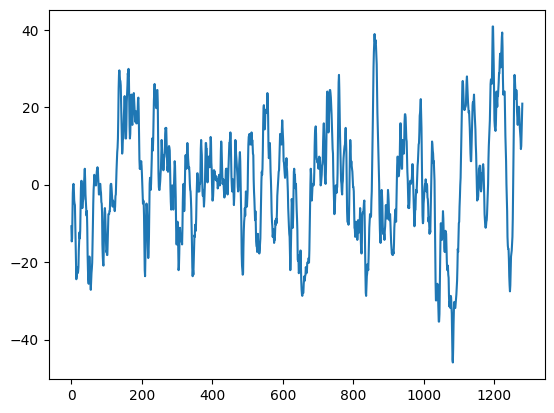

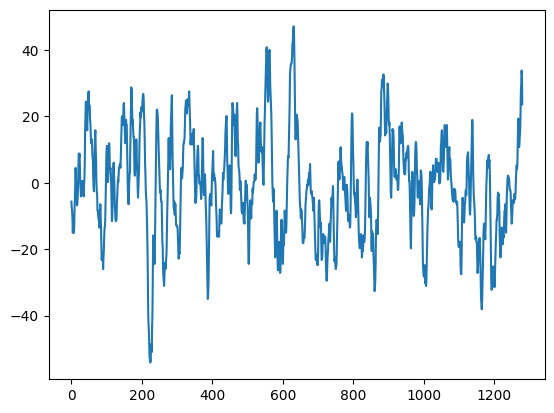

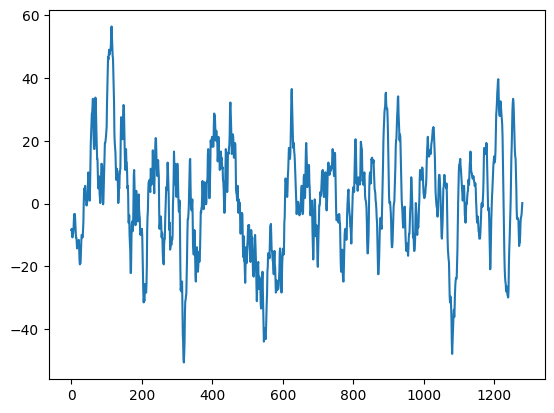

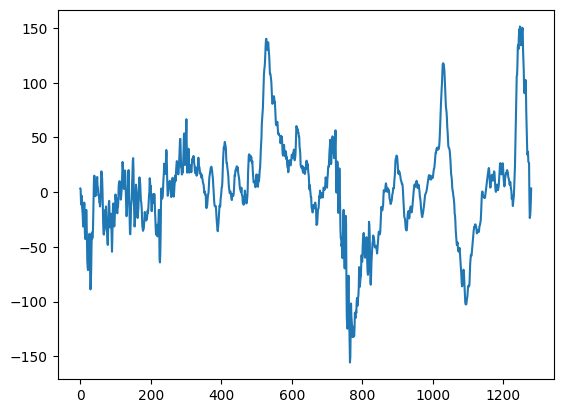

In [ ]:
sample_signals = non_seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

Preparing final data

In [ ]:
final_signals = np.zeros((0, 2, WINDOW_SIZE))
final_y_labels = []

In [ ]:
final_signals = np.append(seizure_signals, non_seizure_signals, axis=0)
final_y_labels = np.append(seizure_y_labels, non_seizure_y_labels, axis=0)

print(final_signals.shape, final_y_labels.shape)

(6849, 2, 1280) (6849,)


Plot some of each final signals

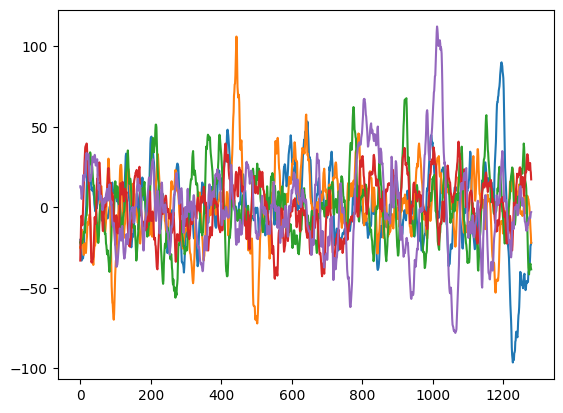

In [ ]:
for i in range(len(final_signals[0:5])):
    plt.plot(final_signals[i][0])

plt.show()

Feature Extraction

* variance
* std
* mean
* fft
* fft2
* power
* power specular
* complexity
* zero crossing rate

In [ ]:
def func_var(data):
    return np.var(data, axis=2)

def func_std(data):
    return np.std(data, axis=2)

def func_mean(data):
    return np.mean(data, axis=2)

def func_fft(data):
    return np.fft.fft(data, axis=2)

def func_fft_var(data):
    fft = np.fft.fft(data, axis=2)
    return np.var(fft, axis=2)

def func_fft_std(data):
    fft = np.fft.fft(data, axis=2)
    return np.std(fft, axis=2)

def func_fft_mean(data):
    fft = np.fft.fft(data, axis=2)
    return np.mean(fft, axis=2)

def func_fft2_var(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.var(fft2_abs, axis=2)

def func_fft2_std(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.std(fft2_abs, axis=2)

def func_fft2_mean(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.mean(fft2_abs, axis=2)

def func_power(data):
    return np.sum(np.square(data), axis=2)

# calculate power spectral density for each signal
def func_power_specular_var(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_std(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_mean(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_complexity(data):
    fft = np.fft.fft(data)
    return np.sum(np.square(np.abs(np.diff(fft, axis=2))), axis=2)

def func_zero_crossing_rate(data):
    return np.sum(np.abs(np.diff(np.sign(data), axis=2)), axis=2)

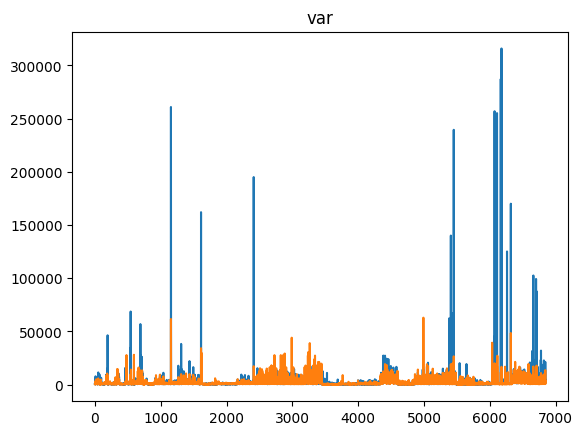

In [ ]:
var = func_var(final_signals)

plt.title('var')
plt.plot(var)
plt.show()

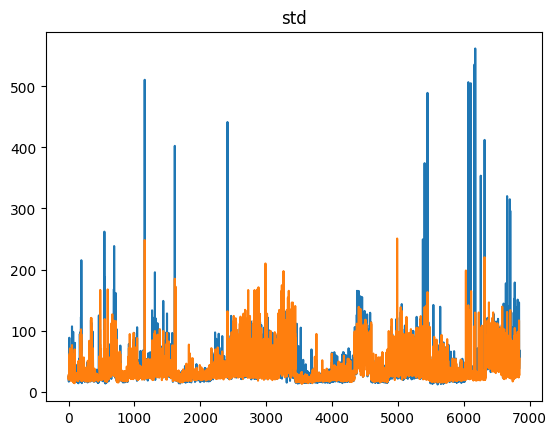

In [ ]:
std = func_std(final_signals)

plt.title('std')
plt.plot(std)
plt.show()

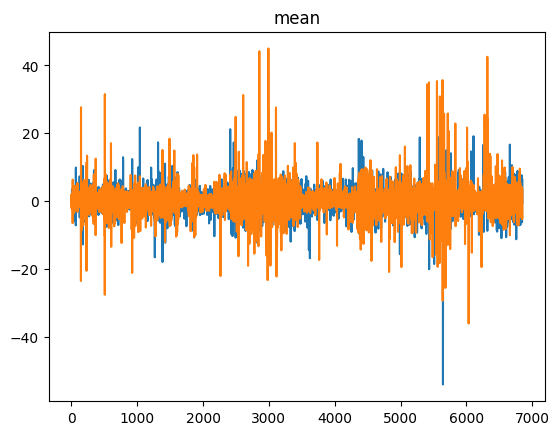

In [ ]:
mean = func_mean(final_signals)

plt.title('mean')
plt.plot(mean)
plt.show()

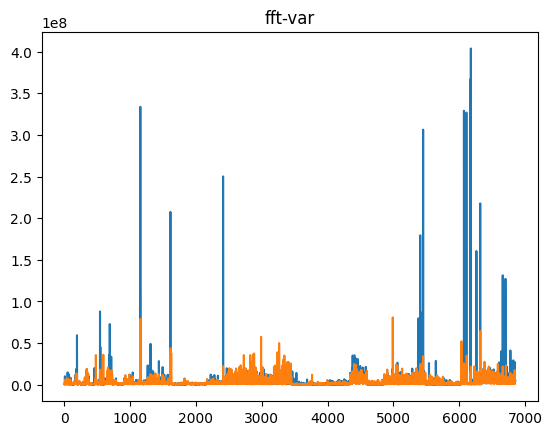

In [ ]:
fft_var = func_fft_var(final_signals)

plt.title('fft-var')
plt.plot(fft_var)
plt.show()

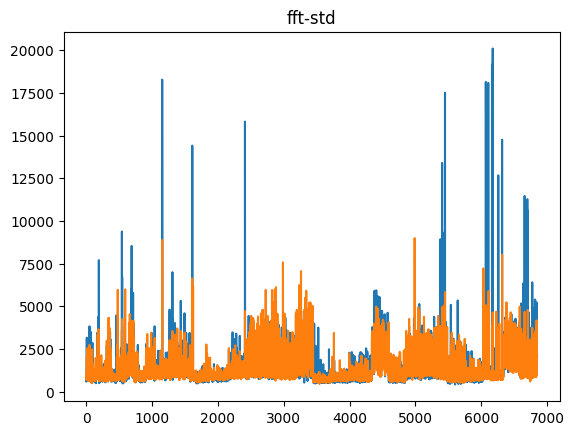

In [ ]:
fft_std = func_fft_std(final_signals)

plt.title('fft-std')
plt.plot(fft_std)
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


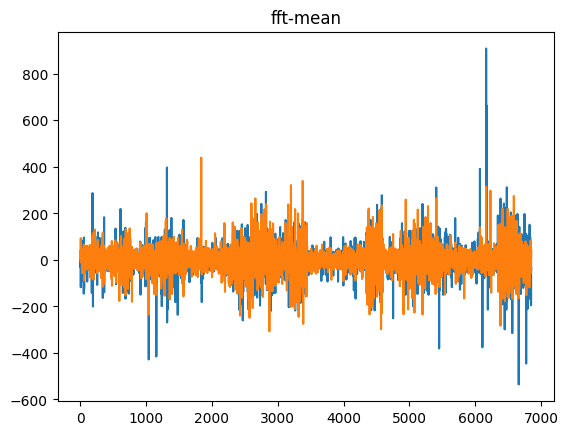

In [ ]:
fft_mean = func_fft_mean(final_signals)

plt.title('fft-mean')
plt.plot(fft_mean)
plt.show()

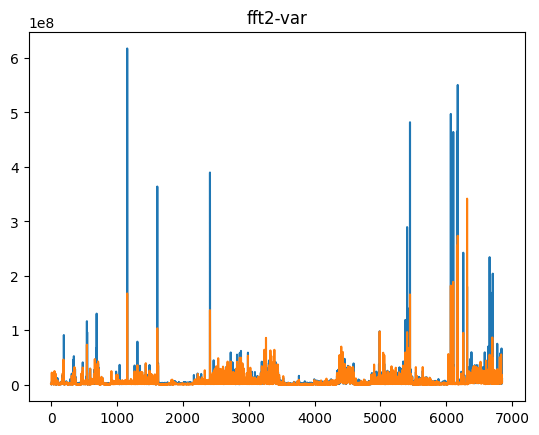

In [ ]:
fft2_var = func_fft2_var(final_signals)

plt.title('fft2-var')
plt.plot(fft2_var)
plt.show()

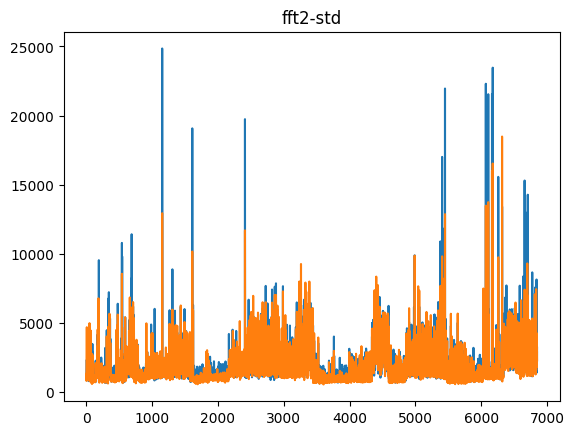

In [ ]:
fft2_std = func_fft2_std(final_signals)

plt.title('fft2-std')
plt.plot(fft2_std)
plt.show()

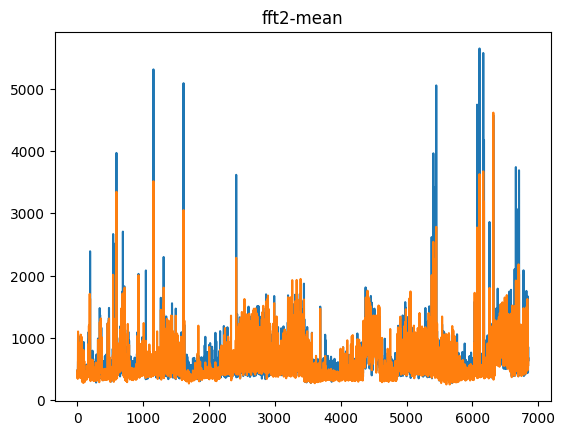

In [ ]:
fft2_mean = func_fft2_mean(final_signals)

plt.title('fft2-mean')
plt.plot(fft2_mean)
plt.show()

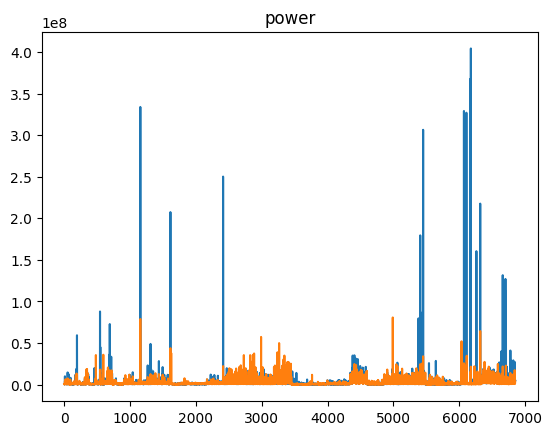

In [ ]:
power = func_power(final_signals)

plt.title('power')
plt.plot(power)
plt.show()

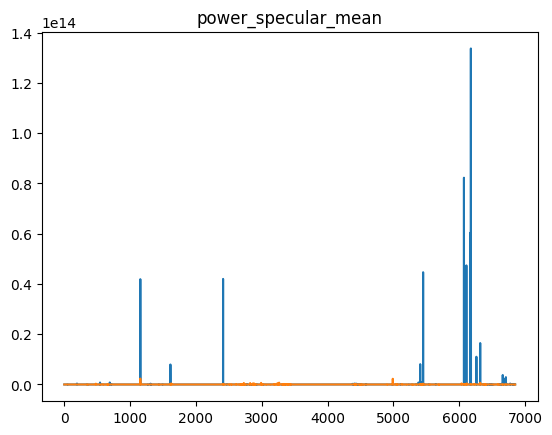

In [ ]:
power_specular_mean = func_power_specular_mean(final_signals)

plt.title('power_specular_mean')
plt.plot(power_specular_mean)
plt.show()

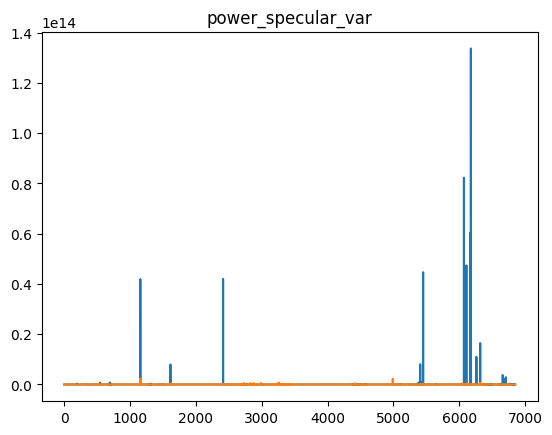

In [ ]:
power_specular_var = func_power_specular_var(final_signals)

plt.title('power_specular_var')
plt.plot(power_specular_var)
plt.show()

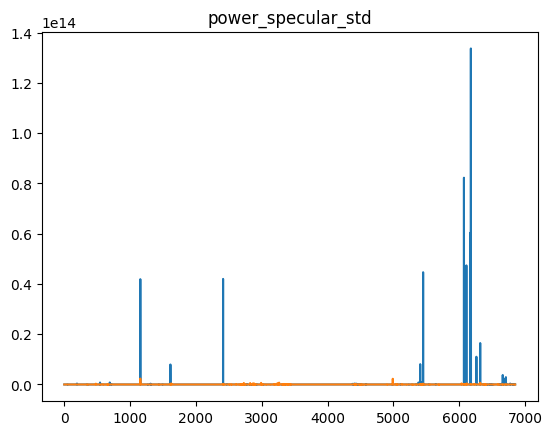

In [ ]:
power_specular_std = func_power_specular_std(final_signals)

plt.title('power_specular_std')
plt.plot(power_specular_std)
plt.show()

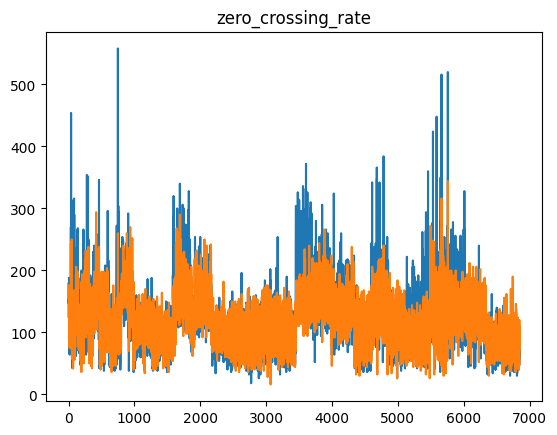

In [ ]:
zero_crossing_rate = func_zero_crossing_rate(final_signals)

plt.title('zero_crossing_rate')
plt.plot(zero_crossing_rate)
plt.show()

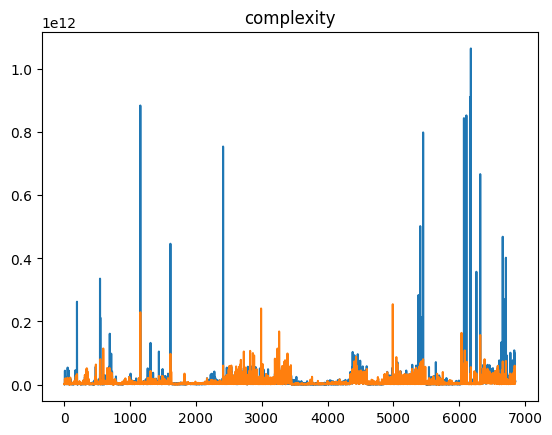

In [ ]:
complexity = func_complexity(final_signals)

plt.title('complexity')
plt.plot(complexity)
plt.show()

Concatenating the features

In [ ]:
features = np.concatenate((var
                          ,std
                          ,mean
                          ,fft_var
                          ,fft_std
                          ,fft2_var
                          ,fft2_std
                          ,fft2_mean
                          ,power
                          ,power_specular_var
                          ,power_specular_std
                          ,power_specular_mean
                          ,zero_crossing_rate
                          ,complexity), axis=1)

features.shape

(6849, 28)

0.9007299270072993
[[1234    0]
 [ 136    0]]


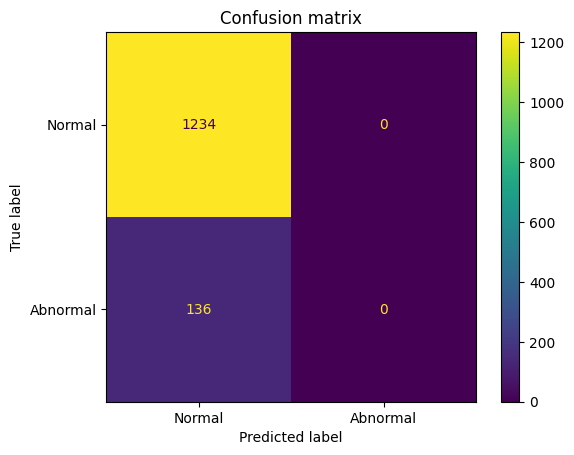

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

clf.fit(x_train, y_train)

y_prediction = clf.predict(x_test)

print(accuracy_score(y_test, y_prediction))

print(confusion_matrix(y_test, y_prediction))

cm = confusion_matrix(y_test, y_prediction)

display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Abnormal'])
display.plot()
display.ax_.set_title('Confusion matrix')
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(final_signals, final_y_labels, test_size=0.2, random_state=42)

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

CNN

A neural network with 3 convolutional layers, 3 max pooling and 2 fully connected layers.

* Kernel Size = Size of window
* Filter = Number of filter
* Dense Layer = Number of neurons
* Dropout Layer = Number of neurons in dropping level

In [ ]:
KERNEL_SIZE = 5
FILTER_SIZE = 256
POOL_SIZE = 2
DROPOUT = 0.3
DENSE_1 = 256
DENSE_2 = 2

sequential = Sequential()

sequential.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 2
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 4
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Flatten())

#add our features to the last fully connected layer
sequential.add(Dense(DENSE_1, activation='relu'))
sequential.add(Dense(DENSE_2, activation='softmax'))

sequential.summary()

sequential.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1276, 256)         2816      
                                                                 
 max_pooling1d (MaxPooling1  (None, 638, 256)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 638, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 634, 128)          163968    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 317, 128)          0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 317, 128)          0

In [ ]:
x_train = x_train.reshape(x_train.shape[0], WINDOW_SIZE, 2).astype('float32')
x_test = x_test.reshape(x_test.shape[0], WINDOW_SIZE, 2).astype('float32')

In [ ]:
sequential.fit(x_train, y_train_categorical, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
172/172 - 132s - loss: 1.1877 - accuracy: 0.9170 - 132s/epoch - 768ms/step
Epoch 2/10
172/172 - 122s - loss: 0.3150 - accuracy: 0.9204 - 122s/epoch - 709ms/step
Epoch 3/10
172/172 - 123s - loss: 0.3064 - accuracy: 0.9204 - 123s/epoch - 713ms/step
Epoch 4/10
172/172 - 122s - loss: 0.2800 - accuracy: 0.9204 - 122s/epoch - 708ms/step
Epoch 5/10
172/172 - 128s - loss: 0.2794 - accuracy: 0.9204 - 128s/epoch - 743ms/step
Epoch 6/10
172/172 - 121s - loss: 0.2788 - accuracy: 0.9204 - 121s/epoch - 702ms/step
Epoch 7/10
172/172 - 120s - loss: 0.2789 - accuracy: 0.9204 - 120s/epoch - 698ms/step
Epoch 8/10
172/172 - 121s - loss: 0.2834 - accuracy: 0.9204 - 121s/epoch - 701ms/step
Epoch 9/10
172/172 - 120s - loss: 0.2787 - accuracy: 0.9204 - 120s/epoch - 699ms/step
Epoch 10/10
172/172 - 127s - loss: 0.2778 - accuracy: 0.9204 - 127s/epoch - 737ms/step


In [ ]:
model_loss, model_accuracy = sequential.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

43/43 - 10s - loss: 0.3263 - accuracy: 0.9007 - 10s/epoch - 223ms/step
CNN - Loss: 0.32625681161880493, Accuracy: 0.9007299542427063


In [ ]:
y_prediction = sequential.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_prediction))

43/43 [==============================] - 21s 460ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1234
           1       0.00      0.00      0.00       136

    accuracy                           0.90      1370
   macro avg       0.45      0.50      0.47      1370
weighted avg       0.81      0.90      0.85      1370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
matrix = confusion_matrix(y_test, y_prediction)

true_positive = matrix[0][0]
false_positive = matrix[0][1]
true_negative = matrix[1][0]
false_negative = matrix[1][1]

false_alarm_rate = false_positive / (true_positive + false_positive)
missing_rate = true_negative / (true_negative + false_negative)

print(f'false alarm rate: {false_alarm_rate}, missing rate: {missing_rate}')

false alarm rate: 0.0, missing rate: 1.0


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

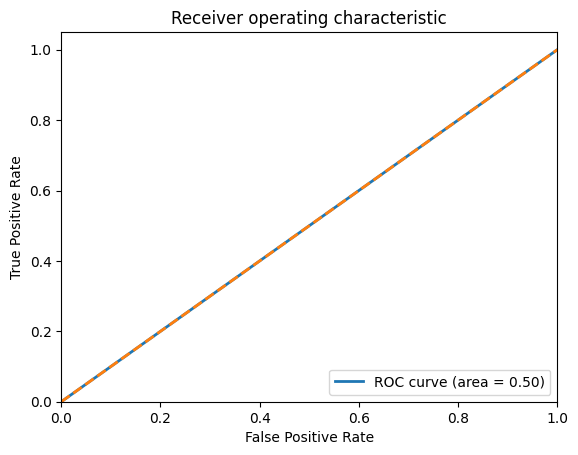

In [ ]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
LEARNING_RATE = 0.01

sequential_b = Sequential()
sequential_b.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential_b.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential_b.add(BatchNormalization())
sequential_b.add(Conv1D(filters=FILTER_SIZE / 2
                ,kernel_size=KERNEL_SIZE
                ,activation='relu'
                ,input_shape=(WINDOW_SIZE, 2)))

sequential_b.add(Flatten())

sequential_b.add(Dense(features.shape[1], activation='relu'))
sequential_b.add(Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

sequential_b.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sequential_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1276, 256)         2816      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 638, 256)          0         
 g1D)                                                            
                                                                 
 batch_normalization (Batch  (None, 638, 256)          1024      
 Normalization)                                                  
                                                                 
 conv1d_4 (Conv1D)           (None, 634, 128)          163968    
                                                                 
 flatten_1 (Flatten)         (None, 81152)             0         
                                                                 
 dense_2 (Dense)             (None, 28)               

In [ ]:
sequential_b.fit(x_train, y_train_categorical, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
172/172 - 123s - loss: 0.8090 - accuracy: 0.9018 - 123s/epoch - 718ms/step
Epoch 2/10
172/172 - 115s - loss: 0.5221 - accuracy: 0.9204 - 115s/epoch - 668ms/step
Epoch 3/10
172/172 - 117s - loss: 0.4457 - accuracy: 0.9204 - 117s/epoch - 680ms/step
Epoch 4/10
172/172 - 115s - loss: 0.3931 - accuracy: 0.9204 - 115s/epoch - 668ms/step
Epoch 5/10
172/172 - 114s - loss: 0.3569 - accuracy: 0.9204 - 114s/epoch - 662ms/step
Epoch 6/10
172/172 - 115s - loss: 0.3319 - accuracy: 0.9204 - 115s/epoch - 666ms/step
Epoch 7/10
172/172 - 114s - loss: 0.3146 - accuracy: 0.9204 - 114s/epoch - 662ms/step
Epoch 8/10
172/172 - 114s - loss: 0.3027 - accuracy: 0.9204 - 114s/epoch - 661ms/step
Epoch 9/10
172/172 - 114s - loss: 0.2944 - accuracy: 0.9204 - 114s/epoch - 660ms/step
Epoch 10/10
172/172 - 114s - loss: 0.2887 - accuracy: 0.9204 - 114s/epoch - 662ms/step


In [ ]:
model_loss, model_accuracy = sequential_b.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

43/43 - 7s - loss: 0.3257 - accuracy: 0.9007 - 7s/epoch - 152ms/step
CNN - Loss: 0.32570210099220276, Accuracy: 0.9007299542427063


In [ ]:
y_prediction = sequential_b.predict(x_test)
sequential_b.save('model.h5')
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_prediction))

43/43 [==============================] - 14s 324ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1234
           1       0.00      0.00      0.00       136

    accuracy                           0.90      1370
   macro avg       0.45      0.50      0.47      1370
weighted avg       0.81      0.90      0.85      1370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
matrix = confusion_matrix(y_test, y_prediction)

true_positive = matrix[0][0]
false_positive = matrix[0][1]
true_negative = matrix[1][0]
false_negative = matrix[1][1]

false_alarm_rate = false_positive / (true_positive + false_positive)
missing_rate = true_negative / (true_negative + false_negative)

print(f'false alarm rate: {false_alarm_rate}, missing rate: {missing_rate}')

false alarm rate: 0.0, missing rate: 1.0


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

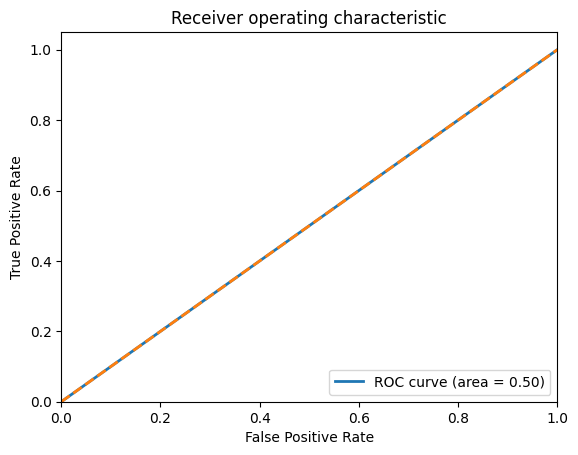

In [ ]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()